# Arabic Handwritten Characters recognition

   ## Importing the necessary libraries


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tflearn
import matplotlib.pyplot as plt
import seaborn as sns
import tflearn.data_utils as du
import random

from tflearn.data_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
%matplotlib inline

Using TensorFlow backend.


## Loading the dataset

In [2]:
train_data = pd.read_csv('./dataset/csvTrainImages 13440x1024.csv', header = None)
train_label = pd.read_csv('./dataset/csvTrainLabel 13440x1.csv', header = None)
test_data = pd.read_csv('./dataset/csvTestImages 3360x1024.csv', header = None)
test_label = pd.read_csv('./dataset/csvTestLabel 3360x1.csv', header = None)


In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13440 entries, 0 to 13439
Columns: 1024 entries, 0 to 1023
dtypes: int64(1024)
memory usage: 105.0 MB


In [4]:
train_data.head()

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
train_data = train_data.values.astype('float32')
train_label = train_label.values.astype('int32')-1
test_data = test_data.values.astype('float32')
test_label = test_label.values.astype('int32')-1


In [6]:
train_label

array([[ 0],
       [ 0],
       [ 0],
       ...,
       [27],
       [27],
       [27]], dtype=int32)

In [7]:
train_data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## Data reshape

In [8]:
print(train_data.shape, train_label.shape, test_data.shape, test_label.shape)

(13440, 1024) (13440, 1) (3360, 1024) (3360, 1)


In [9]:
train_data = train_data.reshape([-1, 32, 32, 1])
test_data = test_data.reshape([-1, 32, 32, 1])

In [10]:
print(train_data.shape, train_label.shape, test_data.shape, test_label.shape)

(13440, 32, 32, 1) (13440, 1) (3360, 32, 32, 1) (3360, 1)


In [11]:
train_data

array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
 

In [12]:
train_label

array([[ 0],
       [ 0],
       [ 0],
       ...,
       [27],
       [27],
       [27]], dtype=int32)

## Visualizing the dataset

In [13]:
def disply_image(X, y):

    arabic_labels = ['alef', 'beh', 'teh', 'theh', 'jeem', 'hah', 'khah', 'dal', 'thal',
                'reh', 'zain', 'seen', 'sheen', 'sad', 'dad', 'tah', 'zah', 'ain', 
                'ghain', 'feh', 'qaf', 'kaf', 'lam', 'meem', 'noon', 'heh', 'waw', 'yeh']
    
    x = random.randint(0, 3360)
    plt.imshow(X[x].squeeze().T)
    plt.title(arabic_labels[int(y[x][0])])

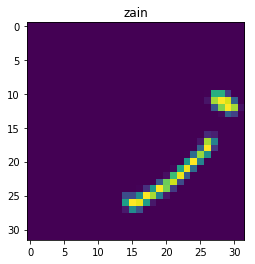

In [14]:
disply_image(train_data, train_label)

## Data preprocessing 
###  Encoding categorical variables

In [15]:
train_label = [i[0] for i in train_label]
# test_label = [i[0] for i in test_label]

In [16]:
train_label = to_categorical(train_label,28)
# test_label = to_categorical(test_label, 28)

In [17]:
train_label

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

### Normalizarion

In [18]:
train_data = train_data/255
test_data = test_data/255

In [19]:
train_data

array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
 

In [20]:
train_data, mean1 = du.featurewise_zero_center(train_data)
test_data, mean2 = du.featurewise_zero_center(test_data)

In [21]:
train_data

array([[[[-4.7677409e-04],
         [-8.3741827e-05],
         [-3.8223625e-05],
         ...,
         [-2.1446077e-04],
         [-2.4101308e-04],
         [-8.9840108e-04]],

        [[-1.6427404e-04],
         [-4.7852474e-05],
         [-2.9178338e-05],
         ...,
         [-2.0220589e-04],
         [-1.5639588e-04],
         [-2.9761906e-04]],

        [[-1.2750934e-04],
         [-5.2521009e-06],
         [-1.0270775e-04],
         ...,
         [-3.4430440e-04],
         [-1.1262839e-04],
         [-1.8820028e-04]],

        ...,

        [[-8.5492531e-05],
         [-9.9206354e-06],
         [-7.7614386e-05],
         ...,
         [-5.6285015e-04],
         [-4.0820497e-04],
         [-6.3608779e-04]],

        [[-1.7419468e-04],
         [-5.9523809e-05],
         [-7.0903363e-05],
         ...,
         [-4.3388191e-04],
         [-4.0616246e-04],
         [-1.0279529e-03]],

        [[-1.8913400e-03],
         [-8.5375819e-04],
         [-5.7160365e-04],
         ...,
 

## Building the CNN


In [22]:
recognizer = Sequential()

recognizer.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (32,32,1)))
recognizer.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
recognizer.add(MaxPool2D(pool_size=(2,2)))
recognizer.add(Dropout(0.25))


recognizer.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
recognizer.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
recognizer.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
recognizer.add(Dropout(0.25))


recognizer.add(Flatten())
recognizer.add(Dense(units = 256, activation = 'relu'))
recognizer.add(Dense(units = 256, activation = "relu"))
recognizer.add(Dropout(0.5))
recognizer.add(Dense(28, activation = "softmax"))



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### A summary of the CNN


In [23]:
recognizer.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
__________

In [24]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [25]:
recognizer.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [26]:
datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False,  
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,
        zoom_range = 0.1,  
        width_shift_range=0.1, 
        height_shift_range=0.1,
        horizontal_flip=False,
        validation_split=0.2,
        vertical_flip=False)


In [27]:
datagen.fit(train_data)

## Fitting the CNN to the training data

In [29]:
history = recognizer.fit_generator(datagen.flow(train_data,train_label, batch_size=100),epochs = 30, verbose = 2, steps_per_epoch = train_data.shape[0] // 100)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/30
 - 49s - loss: 2.5733 - acc: 0.2196
Epoch 2/30
 - 53s - loss: 1.5552 - acc: 0.4755
Epoch 3/30
 - 57s - loss: 1.1085 - acc: 0.6209
Epoch 4/30
 - 60s - loss: 0.8638 - acc: 0.7058
Epoch 5/30
 - 52s - loss: 0.6889 - acc: 0.7683
Epoch 6/30
 - 52s - loss: 0.5878 - acc: 0.8022
Epoch 7/30
 - 54s - loss: 0.5028 - acc: 0.8349
Epoch 8/30
 - 54s - loss: 0.4588 - acc: 0.8483
Epoch 9/30
 - 53s - loss: 0.4030 - acc: 0.8696
Epoch 10/30
 - 52s - loss: 0.3535 - acc: 0.8859
Epoch 11/30
 - 53s - loss: 0.3210 - acc: 0.8973
Epoch 12/30
 - 57s - loss: 0.2963 - acc: 0.9037
Epoch 13/30
 - 54s - loss: 0.2860 - acc: 0.9079
Epoch 14/30
 - 60s - loss: 0.2600 - acc: 0.9169
Epoch 15/30
 - 59s - loss: 0.2500 - acc: 0.9191
Epoch 16/30
 - 57s - loss: 0.2328 - acc: 0.9263
Epoch 17/30
 - 53s - loss: 0.2245 - acc: 0.9296
Epoch 18/30
 - 58s - loss: 0.2091 - acc: 0.9323
Epoch 19/30
 - 56s - loss: 0.2075 - acc: 0.9347
Epo

## Making the predictions

In [30]:
predictions = recognizer.predict(test_data)
predictions = np.argmax(predictions,axis = 1)
predictions

array([ 0,  0,  1, ..., 26, 27, 27])

## Generating a confusion matrix

In [31]:
cm = confusion_matrix(test_label, predictions)

## Calculating the accuracy


In [32]:
accuracy = sum(cm[i][i] for i in range(28)) / test_label.shape[0]
print("accuracy = %.3f" %())

accuracy = 0.9714285714285714


dict_keys(['loss', 'acc'])


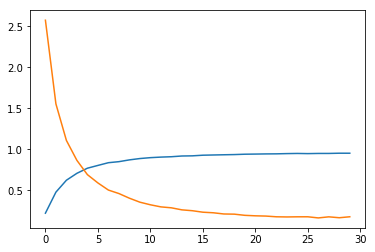